<a href="https://colab.research.google.com/github/YinWang3026/cv_semantic_segmentation/blob/main/fall2021_cv_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fall 2021 Computer Vision

In this project, we will implement **Semantics Segmentation** to identify solar panels in aerial images of cities.

We will use **U-net** for our model, and use **Discriminative Loss Function** for back propagation and training

## Data Preparation

In [ ]:
import os
import numpy as np 
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive/')
### Important Note !!! ###
# Need to add shared folder as a shortcut to My Drive
# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

# Set directory to /code/ folder
%cd /content/drive/My Drive/CV Project Readings/code/

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1t2oLTk-cUAQEFAgf6rY0UTw_vjW4c98Q/CV Project Readings/code


## U-Net Implementation

The model that we have chosen for semantics segmentation is U-Net

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms

class UNet(nn.Module):
  '''
  Input: Tensor [1,3,256,256]
  Output: Tensor [1,1,256,256]
  '''
  def __init__(self):
    super(UNet, self).__init__()
    self.conv0 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.trans3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.trans2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.trans1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.trans0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
    self.uconv3 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.uconv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.uconv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.uconv0 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
    self.convout = nn.Conv2d(32, 1, kernel_size=1)
    
  def forward(self, x):
    # Level 0
    cout0 = self.relu(self.conv0(x))
    cout0 = self.relu(self.conv1(cout0))
    
    # Level 1
    cout1 = self.pool(cout0)
    cout1 = self.relu(self.conv2(cout1))
    cout1 = self.relu(self.conv3(cout1))
    
    # Level 2
    cout2 = self.pool(cout1)
    cout2 = self.relu(self.conv4(cout2))
    cout2 = self.relu(self.conv5(cout2))
    
    # Level 3
    cout3 = self.pool(cout2)
    cout3 = self.relu(self.conv6(cout3))
    cout3 = self.relu(self.conv7(cout3))
    
    # Level 4 (bottom)
    cout4 = self.pool(cout3)
    cout4 = self.relu(self.conv8(cout4))
    cout4 = self.relu(self.conv9(cout4))

    # Level 3
    output = self.trans3(cout4)
    output = torch.cat([output, cout3], dim=1)
    output = self.relu(self.uconv3(output))
    output = self.relu(self.conv7(output))

    # Level 2
    output = self.trans2(output)
    output = torch.cat([output, cout2], dim=1)
    output = self.relu(self.uconv2(output))
    output = self.relu(self.conv5(output))

    # Level 1
    output = self.trans1(output)
    output = torch.cat([output, cout1], dim=1)
    output = self.relu(self.uconv1(output))
    output = self.relu(self.conv3(output))

    # Level 0
    output = self.trans0(output)
    output = torch.cat([output, cout0], dim=1)
    output = self.relu(self.uconv0(output))
    output = self.relu(self.conv1(output))

    # Output
    output = self.convout(output)
    output = self.sigmoid(output)

    return output

In [ ]:
# Dummy data to show proper output dimension calculator
unet = UNet()
x = torch.randn(1,3,256,256)
unet(x).shape

torch.Size([1, 1, 256, 256])

## Dataset Loader

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from csv import reader

class InputDataset(Dataset):
    def __init__(self, train=True, batch_size=4):
        super().__init__()

        self.height = 256
        self.width = 256
        self.color = 1 # single black and white channel
        self.batch_size = batch_size
        #Replace file path based on desired data source
        self.sem_path = "./data/Binary_Chopped_Concatenated_NoEmptyRegions_10PerThresh/Chopped/ContainsPolygons/" #./data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/ContainsPolygons/"
        self.img_path = "./data/Binary_Chopped_Concatenated_NoEmptyRegions_10PerThresh/Chopped/ContainsPolygons/" #./data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/ContainsPolygons/"
        if train:
            self.csv_path = "./data/Binary_Chopped_Concatenated_NoEmptyRegions_10PerThresh/Chopped/ContainsPolygons/csv_file.csv" #"./data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/ContainsPolygons/csv_file.csv"
        else:
            self.csv_path = "./data/Binary_Chopped_Concatenated_NoEmptyRegions_10PerThresh/Chopped/ContainsPolygons/csv_file.csv" #"./data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/ContainsPolygons/csv_file.csv"

        self.img = [] # num img * height * width * color
        self.sem = [] # num img * height * width * color
        self.ins = [] # num img * num poly * height * color
        self.poly_count = [] # num img

        self.row_count = 0

        with open(self.csv_path, 'r') as read_obj:
            csv_reader = reader(read_obj)
            header = next(csv_reader) # Remove header
            print(header)

            for row in csv_reader:
                # row variable is a list that represents a row in csv
                print(row)
                self.row_count += 1

                # reading img
                # 0 = black, 1 = white
                img = cv2.imread(os.path.join(self.img_path, row[1]), cv2.IMREAD_UNCHANGED)
                img = np.transpose(img, (2,0,1)) # Convert (x,y,z) to (z,x,y)
                self.img.append(img)
     
                # reading sem
                sem = cv2.imread(os.path.join(self.sem_path, row[0]), cv2.IMREAD_UNCHANGED)
                self.sem.append(np.true_divide(sem,255)[np.newaxis])

    def __len__(self):
        return self.row_count

    def __getitem__(self, index):
        return self.img[index], self.sem[index]

def dataset_sanity(dataloader):
    # sanity check
    count = 0
    for batched in dataloader:
        print("\nBatch")
        img, sem = batched

        print("Img: ", img.shape, " Type: ", type(img))
        cv2_imshow(np.transpose(img[0].numpy(), (1,2,0)))

        print("Sem: ", sem.shape, " Type: ", type(sem))
        cv2_imshow(np.transpose(sem[0].numpy()*255, (1,2,0)))
        count += 1
        if count == 10:
            break

## Training and Back Propagation

['stockton_450090_bin_11_14_containsPolygon.tif', 'stockton_450090_11_14_containsPolygon.tif']
['stockton_450090_bin_18_2_containsPolygon.tif', 'stockton_450090_18_2_containsPolygon.tif']
['stockton_450075_bin_10_13_containsPolygon.tif', 'stockton_450075_10_13_containsPolygon.tif']
['stockton_450075_bin_11_15_containsPolygon.tif', 'stockton_450075_11_15_containsPolygon.tif']
['stockton_450075_bin_12_14_containsPolygon.tif', 'stockton_450075_12_14_containsPolygon.tif']
['stockton_450060_bin_2_4_containsPolygon.tif', 'stockton_450060_2_4_containsPolygon.tif']
['stockton_450060_bin_3_18_containsPolygon.tif', 'stockton_450060_3_18_containsPolygon.tif']
['stockton_450060_bin_4_16_containsPolygon.tif', 'stockton_450060_4_16_containsPolygon.tif']
['stockton_450045_bin_13_7_containsPolygon.tif', 'stockton_450045_13_7_containsPolygon.tif']
['stockton_450045_bin_14_7_containsPolygon.tif', 'stockton_450045_14_7_containsPolygon.tif']
['stockton_450030_bin_0_1_containsPolygon.tif', 'stockton_450030

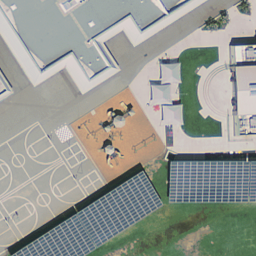

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


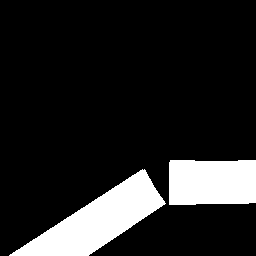


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


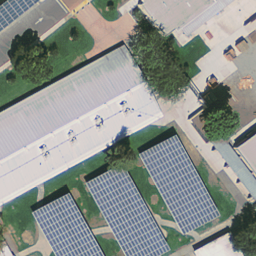

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


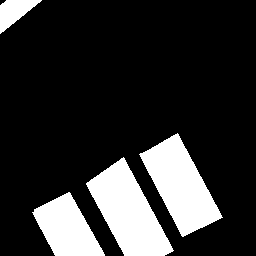


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


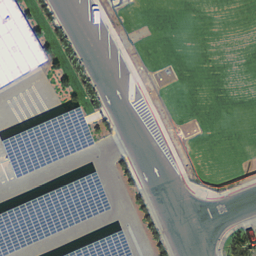

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


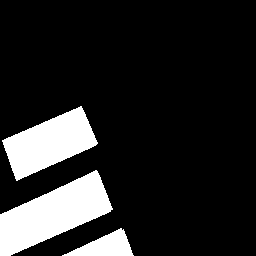


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


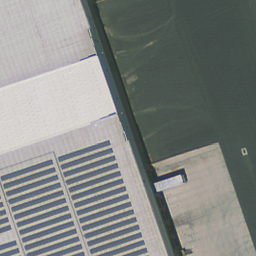

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


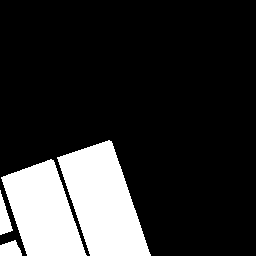


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


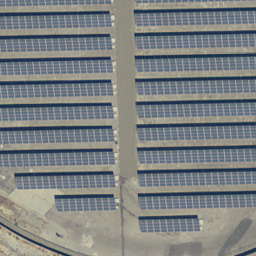

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


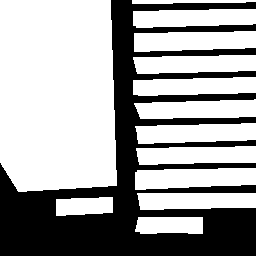


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


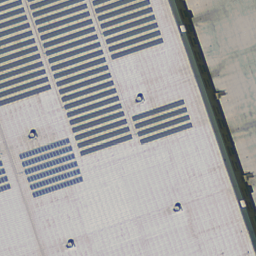

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


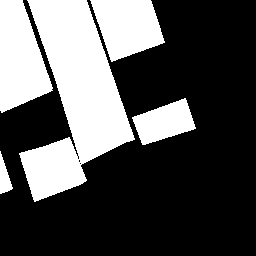


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


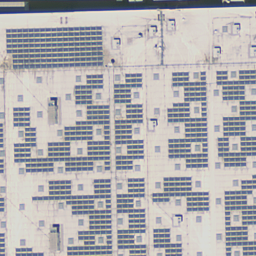

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


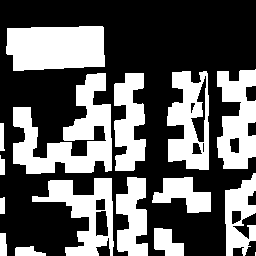


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


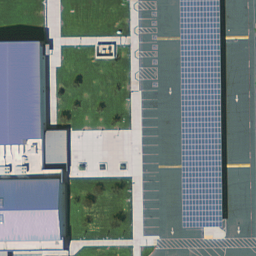

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


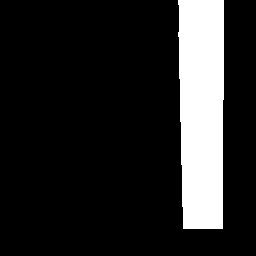


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


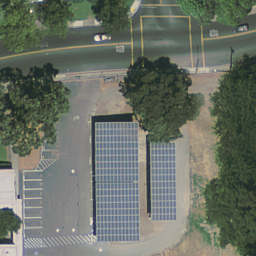

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


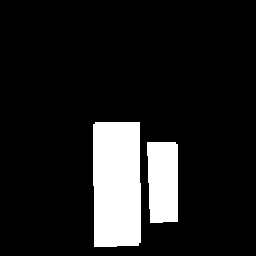


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


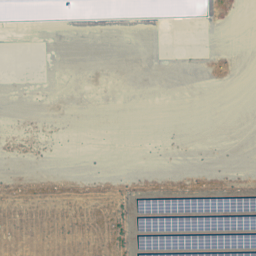

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


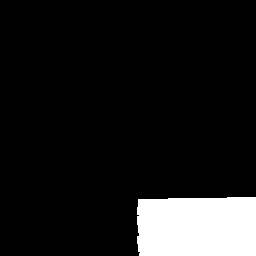


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


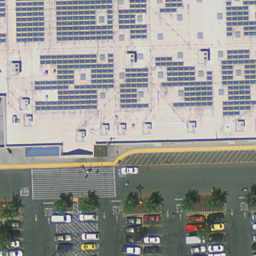

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


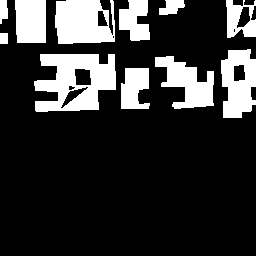


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


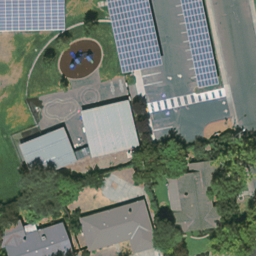

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


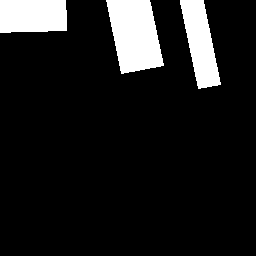


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


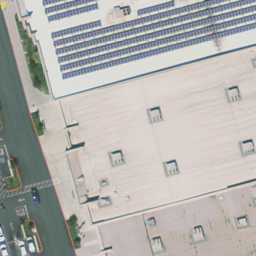

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


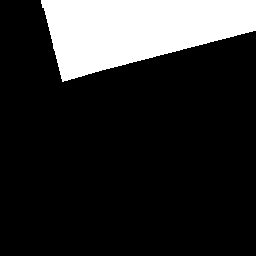


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


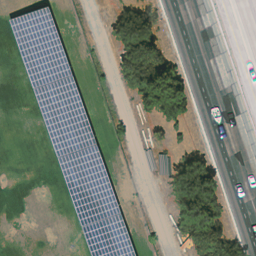

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


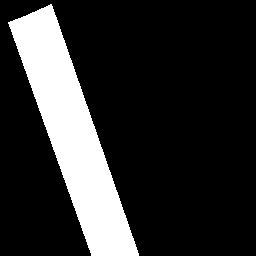


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


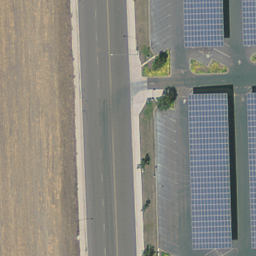

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


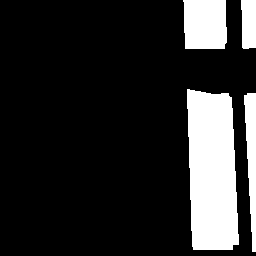


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


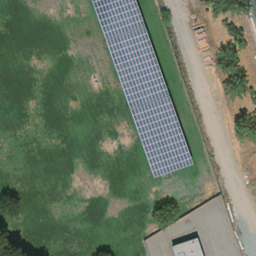

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


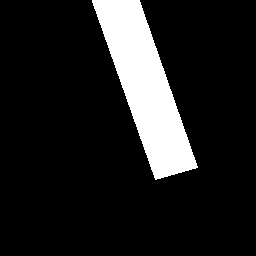


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


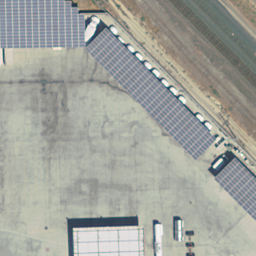

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


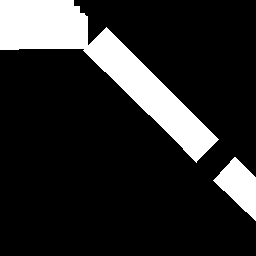


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


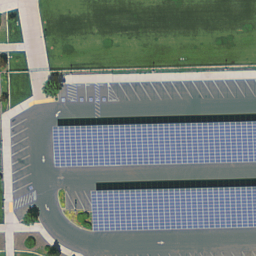

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


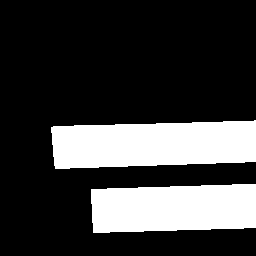


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


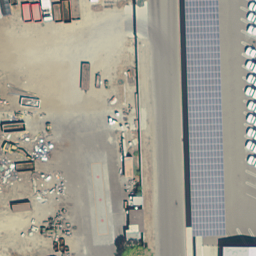

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


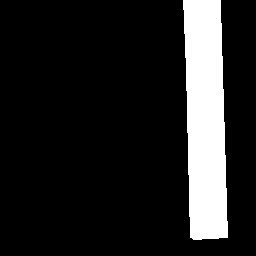


Batch
Img:  torch.Size([1, 3, 256, 256])  Type:  <class 'torch.Tensor'>


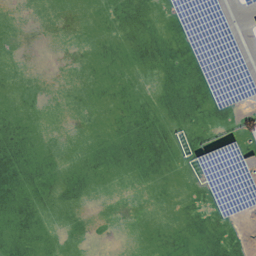

Sem:  torch.Size([1, 1, 256, 256])  Type:  <class 'torch.Tensor'>


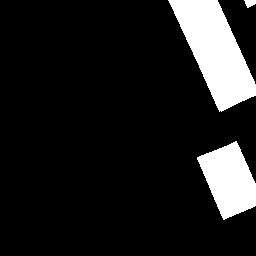

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable

import numpy as np

# model
model = UNet()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# train and test data loader
full_dataset = InputDataset(train=True)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1
)

val_dataloader = DataLoader(val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

dataset_sanity(train_dataloader)
dataset_sanity(val_dataloader)

# loss function
bce_loss_function = nn.BCELoss()

In [ ]:
# training
min_loss = np.inf
avg_loss_hist = [] # Maintain loss history

best_epoch = None
num_epochs = 20
for ep in range(num_epochs):
    print("Currently training epoch {}".format(ep))

    total_losses = 0
    model.train()

    for image, sem_target in train_dataloader:
        # convert to float
        image = image.type(torch.float)
        sem_target = sem_target.type(torch.float)

        # sanity
        # print("image_shape: ", image.shape, " Type: ", image.type()) 
        # image_shape:  torch.Size([1, 3, 256, 256])  Type:  torch.FloatTensor
        # print("sem_target_shape: ", sem_target.shape, " Type: ", sem_target.type()) 
        # sem_target_shape:  torch.Size([1, 1, 256, 256])  Type:  torch.FloatTensor
 
        # passing to model
        model.zero_grad()
        sem_predict = model(image)
        sem_predict = sem_predict.type(torch.float)

        # sanity
        # print("sem_pred_shape: ", sem_predict.shape)
        # sem_pred_shape:  torch.Size([1, 1, 256, 256])
        # cv2_imshow(np.transpose(sem_target[0].detach().numpy()*255, (1,2,0)))
        # cv2_imshow(np.transpose(sem_predict[0].detach().numpy()*255, (1,2,0)))

        # Binary Cross Entropy Loss 
        bce_loss = bce_loss_function(sem_predict, sem_target) # todo check if mean() value here necessary

        # sanity
        # print("Loss")
        # print(bce_loss)

        # back propagtion
        optimizer.zero_grad()
        bce_loss.backward()
        optimizer.step()
        total_losses += bce_loss
    
    avg_bce_loss = float(total_losses / len(train_dataloader))
    print(f'Average loss: {avg_bce_loss:.4f}')
    avg_loss_hist.append(avg_bce_loss)

    lr_scheduler.step()

    if avg_bce_loss < min_loss:
        print("Found better model, saving...")
        min_loss = avg_bce_loss
        file_name = "./model/unet_weights_{}.pth".format(ep)
        torch.save(model.state_dict(), file_name)
        print('Saved model to ' + file_name + '.')
        best_epoch = ep

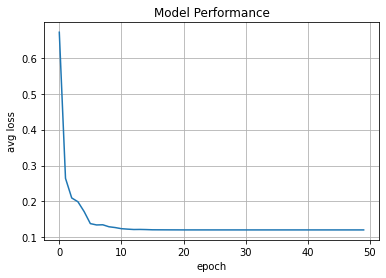

In [ ]:
import matplotlib.pyplot as plt

# Plot simple loss function over time
arr_epochs = np.arange(0, num_epochs)
plt.plot(arr_epochs, avg_loss_hist)
plt.xlabel('epoch')
plt.ylabel('avg loss')
plt.title('Model Performance')
plt.grid()
plt.show()

## Verification

Loading best weights: ./Previously_Trained_Models/50EpochWeights_10PerThresh/unet_weights_35.pth
input:


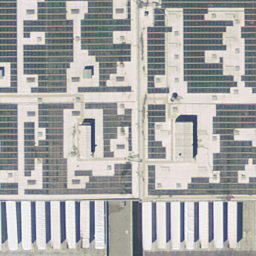

target:


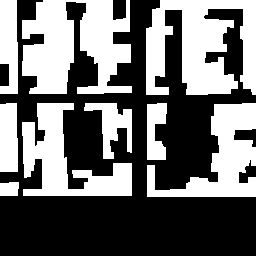

predict:


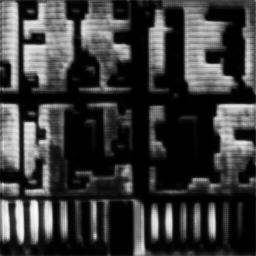

input:


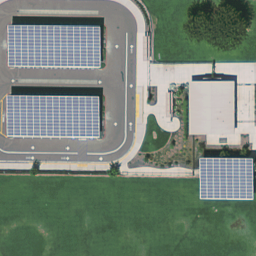

target:


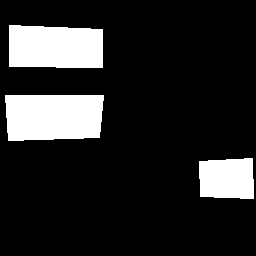

predict:


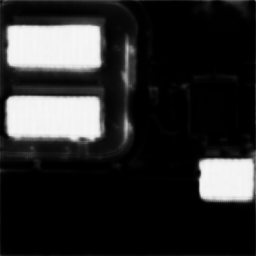

input:


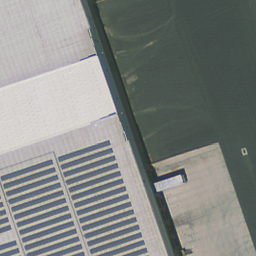

target:


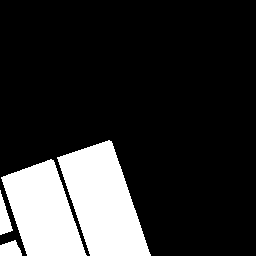

predict:


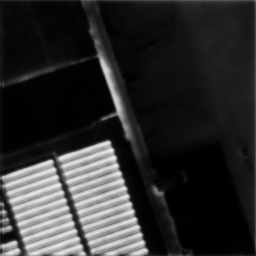

input:


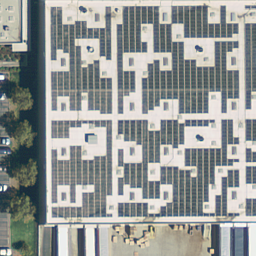

target:


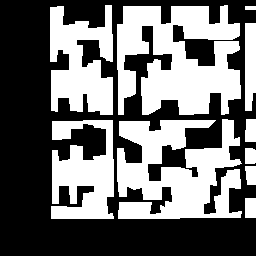

predict:


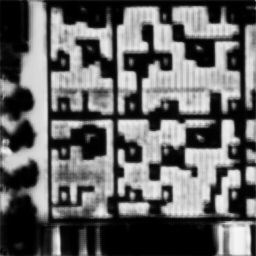

input:


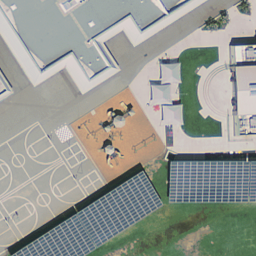

target:


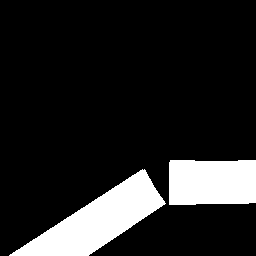

predict:


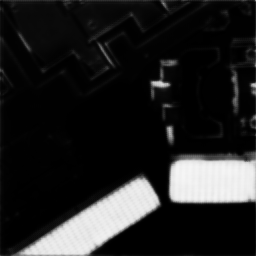

input:


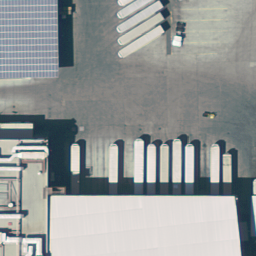

target:


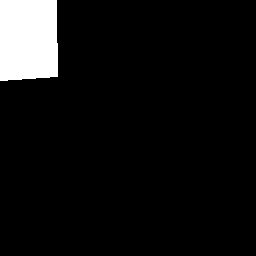

predict:


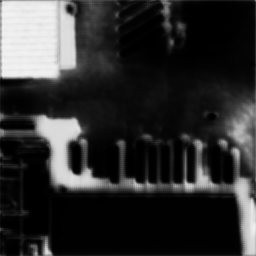

input:


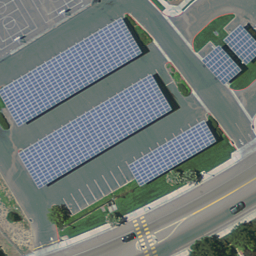

target:


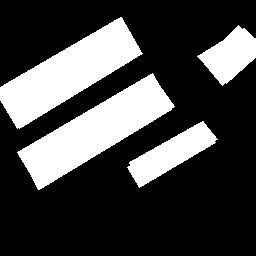

predict:


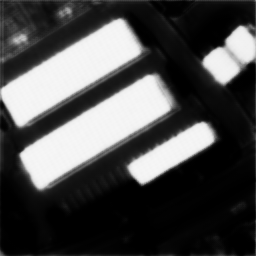

input:


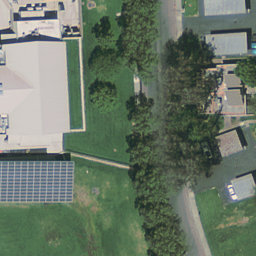

target:


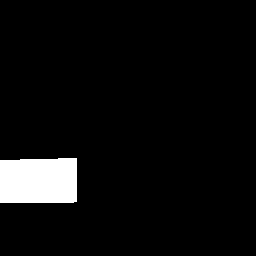

predict:


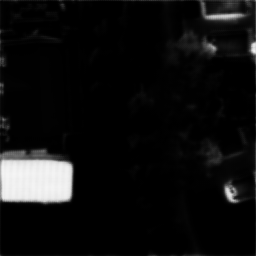

input:


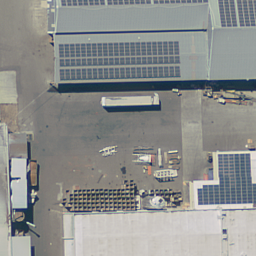

target:


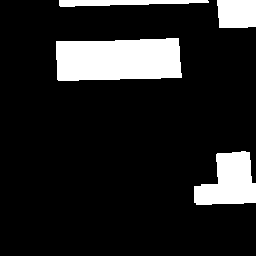

predict:


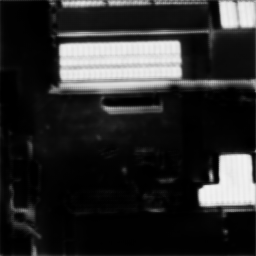

input:


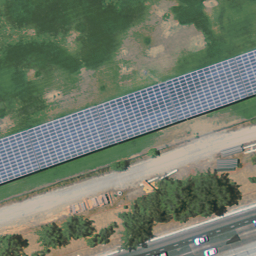

target:


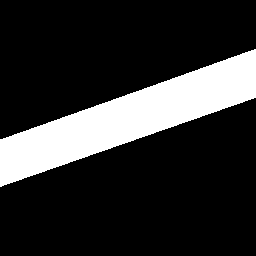

predict:


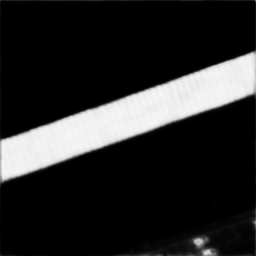

Validation: Binary cross entropy loss: 0.0269


In [ ]:
import os

# Load the weights from Drive
# file_name = "./model/unet_weights_{}.pth".format(best_epoch)
file_name = "./Previously_Trained_Models/20EpochWeights_10PerThresh/unet_weights_35.pth"
# model = UNet() # Create model
print("Loading best weights: " + file_name)
model.load_state_dict(torch.load(file_name)) # Load model
model.eval()


#Output directory changes per output
output_dir = "./data/Results/*20Epochs_10PerThresh_Test/"
# os.mkdir(output_dir)

total_loss = 0
count = 0
for images, sem_labels in val_dataloader:
    # print image
    print("input:")
    cv2_imshow(np.transpose(images[0].numpy(), (1,2,0)))
    cv2.imwrite(output_dir+'input_im_'+str(count)+'.png',np.transpose(images[0].numpy(), (1,2,0)))
    # print label
    print("target:")
    cv2_imshow(np.transpose(sem_labels[0].numpy()*255, (1,2,0)))
    cv2.imwrite(output_dir+'target_im_'+str(count)+'.png',np.transpose(sem_labels[0].numpy(), (1,2,0)))

    # convert to float
    images = images.type(torch.float)
    sem_labels = sem_labels.type(torch.float)

    # passing to model
    sem_predict = model(images)

    # print prediction
    print("predict:")
    cv2_imshow(np.transpose(sem_predict[0].detach().numpy()*255, (1,2,0)))
    cv2.imwrite(output_dir+'predicted_im_'+str(count)+'.png',np.transpose(sem_predict[0].detach().numpy(), (1,2,0)))

    # calculate loss
    bce_loss = bce_loss_function(sem_predict, sem_labels).mean()
    total_loss += bce_loss

    count += 1
    if count == 10:
        break

avg_ce_loss = float(total_loss / len(val_dataloader))
print(f'Validation: Binary cross entropy loss: {avg_ce_loss:.4f}')